In [2]:
from time import time

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
import scipy.misc

In [278]:
def whiten(X, fudge=1E-18):
    Xcov = np.dot(X.T,X)
    d, V = np.linalg.eigh(Xcov)
    D = np.diag(1. / np.sqrt(d+fudge))
    W = np.dot(np.dot(V, D), V.T)
    X_white = np.dot(X, W)
    return X_white, W

def plot_weights(W):
    input_d = int(np.sqrt(W.shape[0]))
    hidden_d = int(np.sqrt(W.shape[1]))

    W_plot = np.zeros((input_d * hidden_d, input_d * hidden_d))
    i = 0
    for y in range(hidden_d):
        for x in range(hidden_d):
            W_plot[
                y*input_d:(y+1)*input_d,
                x*input_d:(x+1)*input_d
            ] = W[:, i].reshape(input_d, input_d)
            i += 1
    return shm(W_plot)

def shm(*matrices, **kwargs):
    plt.figure(1, figsize=(25,10))
    for m_id, matrix in enumerate(matrices):
        plt.subplot(len(matrices), 1, m_id+1)
        plt.imshow(np.squeeze(matrix).T, cmap='gray', origin='lower')
        plt.colorbar()

    if kwargs.get("file"):
        plt.savefig(kwargs["file"])
        plt.clf()
    else:
        plt.show()
    
def to_binary(x):
    return np.where(x > 0, 1.0, 0.0).astype(np.uint8)
        
def relu(x):
    return np.where(x > 0, x, 0.0)

def norm(w, factor=1.0):
    for i in range(w.shape[1]):
        w[:, i] = factor * w[:, i] / np.sqrt(np.sum(np.square(w[:,i])))

def weights_inner_product(W, p):
    return np.asarray([np.linalg.norm(W[:, ni], ord=p) for ni in range(W.shape[1])])

# def shl(*x):
#     plt.figure(figsize=(15,10))
#     for xx in x:
#         plt.plot(xx)
#     plt.show()

def shl(*vector, **kwargs):
    plt.figure(1, figsize=(15,10))
    labels = kwargs.get("labels", [])
    for id, v in enumerate(vector):
        if len(labels) > 0:
            plt.plot(np.squeeze(v), label=labels[id])
        else:
            plt.plot(np.squeeze(v))

    if len(labels) > 0:
        plt.legend()

    if kwargs.get("file"):
        plt.savefig(kwargs["file"])
        plt.clf()
    else:
        plt.show()

In [4]:
face = scipy.misc.face(gray=True)

# Convert from uint8 representation with values between 0 and 255 to
# a floating point representation with values between 0 and 1.
face = face / 255.

# downsample for higher speed
face = face[::4, ::4] + face[1::4, ::4] + face[::4, 1::4] + face[1::4, 1::4]
face /= 4.0
height, width = face.shape

# Extract all reference patches from the left half of the image
print('Extracting reference patches...')
t0 = time()
patch_size = (7, 7)
data = extract_patches_2d(face[:, :width // 2], patch_size)
data = data.reshape(data.shape[0], -1)
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)
data, W_whiten = whiten(data)
print('done in %.2fs.' % (time() - t0))

Extracting reference patches...
done in 0.07s.


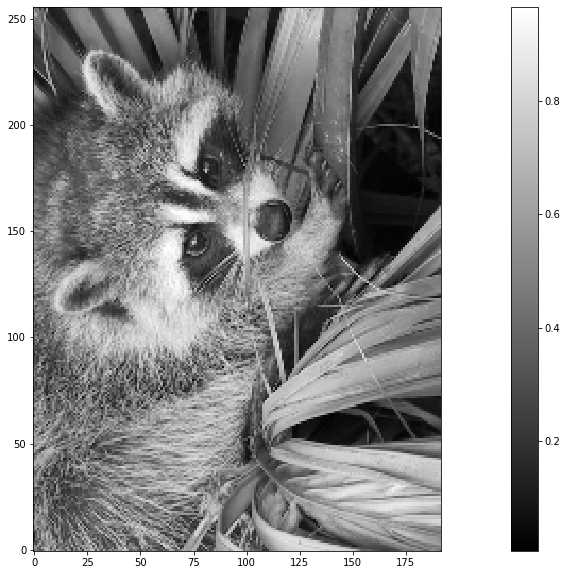

In [5]:
shm(face)

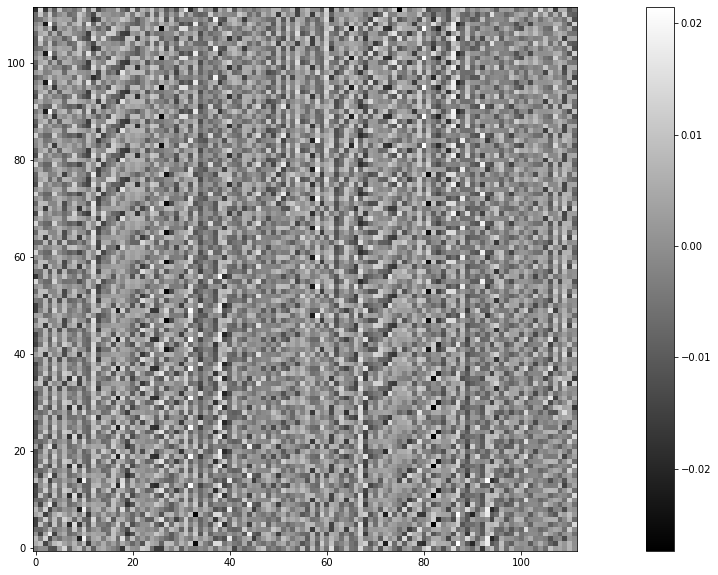

In [6]:
plot_weights(data[:256].T)

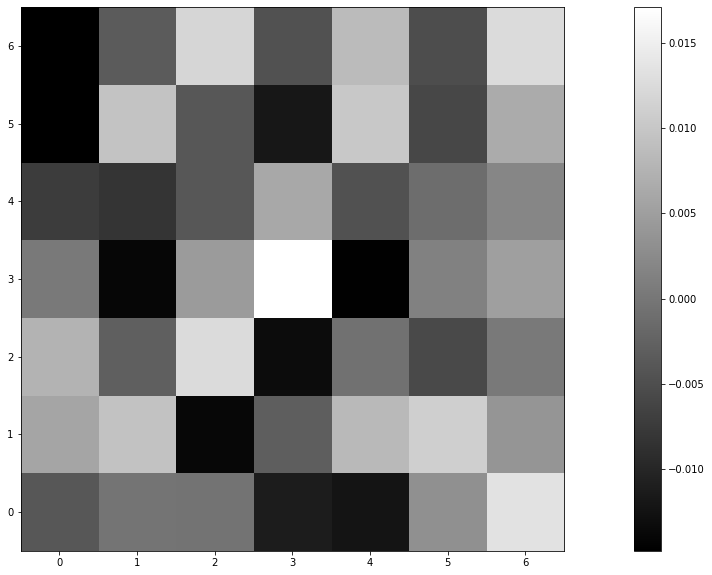

In [7]:
shm(data[0].reshape(patch_size))

In [345]:
X = data

np.random.seed(3)
theta = 0.0
a = 10.0
b = 1.0
epochs = 500
learning_rate = 0.1
batch_size = 200
num_hidden = 49
number_of_batches = X.shape[0] // batch_size
dt = 0.1

tau_avg = 100.0

W = np.random.normal(0.0, 1.0, (X.shape[1], num_hidden))
norm(W)

R = np.zeros((num_hidden, num_hidden))
# R = 0.01 * np.abs(np.random.normal(0.0, 1.0, (num_hidden, num_hidden)))
np.fill_diagonal(R, 0)

W0 = W.copy()
R0 = R.copy()

In [346]:
i = 0
x = X[i*batch_size:(i+1)*batch_size,:]

num_iters = 10
du_stat = np.zeros((num_iters, batch_size, num_hidden))
y_stat = np.zeros((num_iters, batch_size, num_hidden))
u_stat = np.zeros((num_iters, batch_size, num_hidden))

y = np.zeros((batch_size, num_hidden))
u = np.zeros((batch_size, num_hidden))
for it in range(num_iters):
    du = np.dot(x, W) - np.dot(y, R)
    u += dt * du
    y = a * relu(u - theta)
    du_stat[it] = np.linalg.norm(du)

    y_stat[it] = y.copy()
    u_stat[it] = u.copy()
    du_stat[it] = du.copy()


In [369]:
y_stat = np.zeros((epochs, num_hidden))
converge_stat = np.zeros((epochs, 2))

y_avg = np.zeros((num_hidden,))
y_avg_stat = np.zeros((epochs, num_hidden))

for epoch in range(epochs):
    dW_norm = 0.0
    dR_norm = 0.0

    for i in range(number_of_batches):
        x = X[i*batch_size:(i+1)*batch_size,:]
        
        y = np.zeros((batch_size, num_hidden))
        u = np.zeros((batch_size, num_hidden))
        for _ in range(5):
            du = np.dot(x, W) - np.dot(y, R)
            u += dt * du
            y = a * relu(u - theta)
            
#         y = a * relu(np.dot(x, W) - theta)

        # statistics

        y_avg_cur = np.mean(y, 0)
        y_stat[epoch] += y_avg_cur
        
        y_avg = (1.0 - 1.0 / tau_avg) * y_avg + (1.0 / tau_avg) * y_avg_cur
        y_avg_stat[epoch] += y_avg
        
        # learning
        
        if epoch < 10:
            continue

        y_deriv = y * (y - y_avg)
#         y_deriv = y

        dR = np.dot(y.T, y)        
        dW = np.dot(x.T, y_deriv)
        
        dW_norm += np.linalg.norm(dW)
        dR_norm += np.linalg.norm(dR)
        
        W += learning_rate * dW
        R += learning_rate * dR
        np.fill_diagonal(R, 0)
        
    norm(W)
    
    y_stat[epoch] /= number_of_batches
    y_avg_stat[epoch] /= number_of_batches

    converge_stat[epoch, 0] = dW_norm / number_of_batches
    converge_stat[epoch, 1] = dR_norm / number_of_batches
    
    if epoch % (epochs // 10) == 0 or epoch == epochs - 1:
        print(
            "Epoch {}, "
            "|dW| = {:.3f}, "
            "min(W) = {:.3f}, "
            "max(W) = {:.3f}, "
            "|W| = {:.3f}, "
            "|dR| = {:.3f}, "
            "<y> = {:.3f}".format(
            epoch, 
            converge_stat[epoch, 0],
            np.min(W),
            np.max(W),
            weights_inner_product(W, 2)[0],
            converge_stat[epoch, 1],
            np.mean(y_stat[epoch])
            #np.mean(weights_inner_product(W, 2))
        ))    

Epoch 0, |dW| = 0.000, min(W) = -0.489, max(W) = 0.465, |W| = 1.000, |dR| = 0.000, <y> = 0.001
Epoch 50, |dW| = 0.011, min(W) = -0.488, max(W) = 0.468, |W| = 1.000, |dR| = 0.224, <y> = 0.001
Epoch 100, |dW| = 0.011, min(W) = -0.487, max(W) = 0.470, |W| = 1.000, |dR| = 0.216, <y> = 0.001
Epoch 150, |dW| = 0.010, min(W) = -0.485, max(W) = 0.473, |W| = 1.000, |dR| = 0.210, <y> = 0.001
Epoch 200, |dW| = 0.010, min(W) = -0.484, max(W) = 0.475, |W| = 1.000, |dR| = 0.204, <y> = 0.001
Epoch 250, |dW| = 0.010, min(W) = -0.483, max(W) = 0.478, |W| = 1.000, |dR| = 0.200, <y> = 0.001
Epoch 300, |dW| = 0.010, min(W) = -0.481, max(W) = 0.480, |W| = 1.000, |dR| = 0.196, <y> = 0.001
Epoch 350, |dW| = 0.010, min(W) = -0.480, max(W) = 0.482, |W| = 1.000, |dR| = 0.192, <y> = 0.001
Epoch 400, |dW| = 0.009, min(W) = -0.479, max(W) = 0.483, |W| = 1.000, |dR| = 0.189, <y> = 0.001
Epoch 450, |dW| = 0.009, min(W) = -0.478, max(W) = 0.485, |W| = 1.000, |dR| = 0.186, <y> = 0.001
Epoch 499, |dW| = 0.009, min(W) =

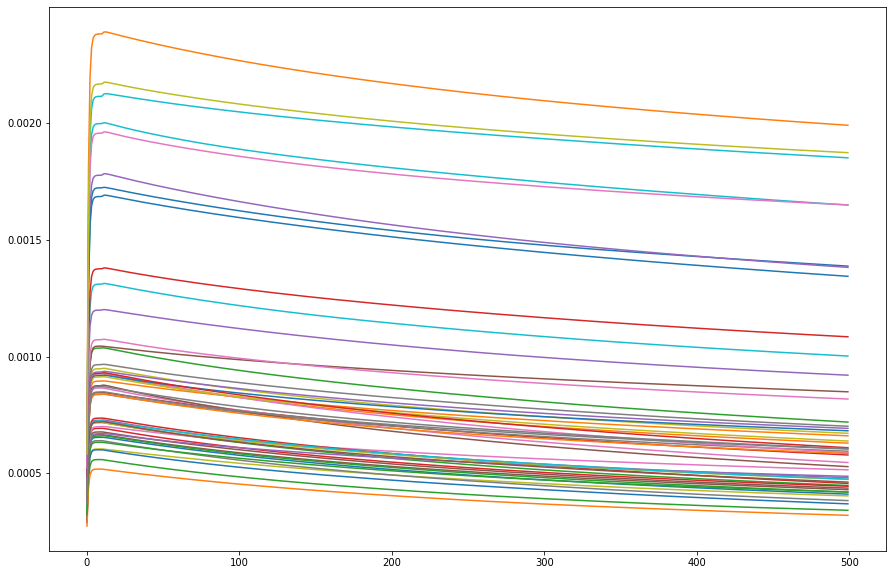

In [370]:
shl(y_avg_stat)

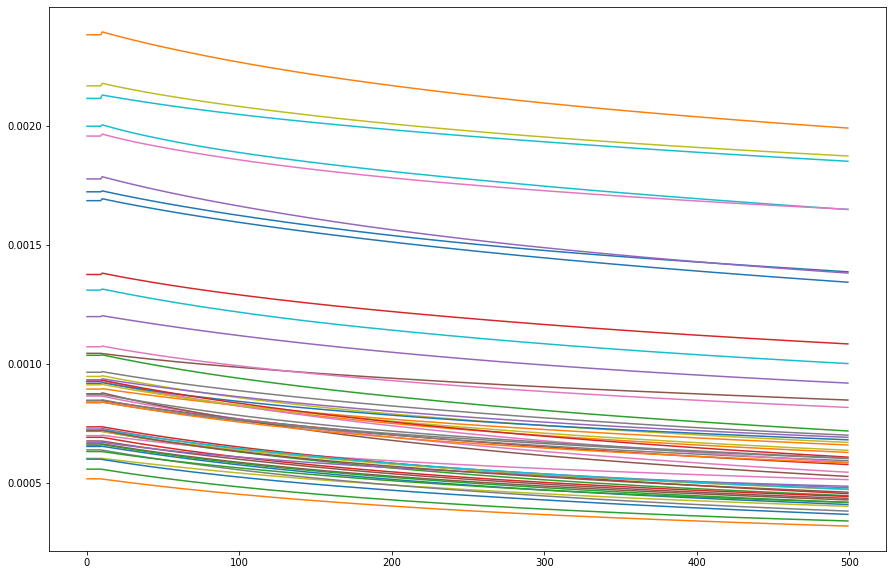

In [371]:
shl(y_stat)

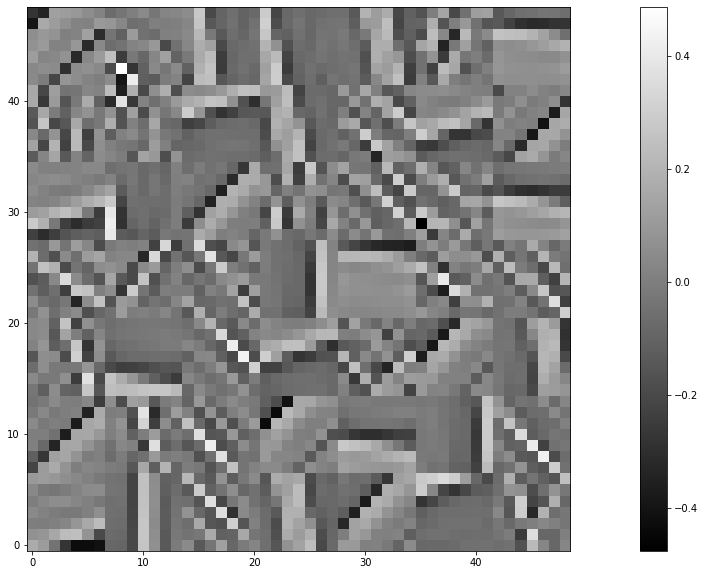

In [372]:
plot_weights(W)

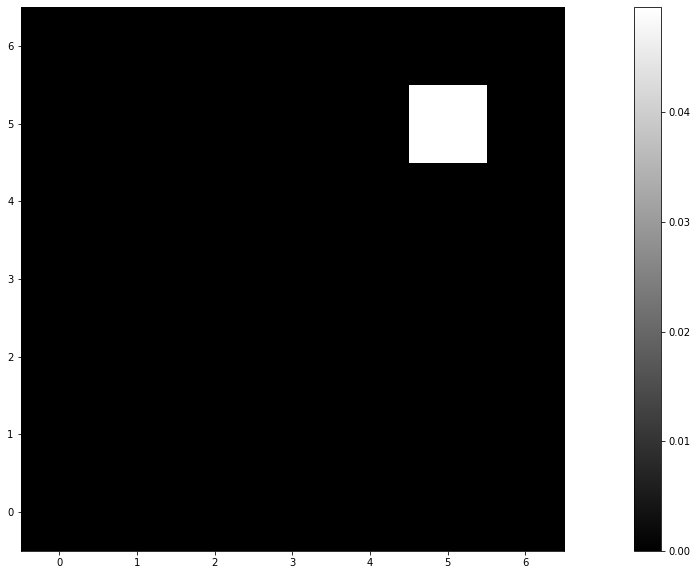

In [373]:
shm(y[6].reshape((7,7)))

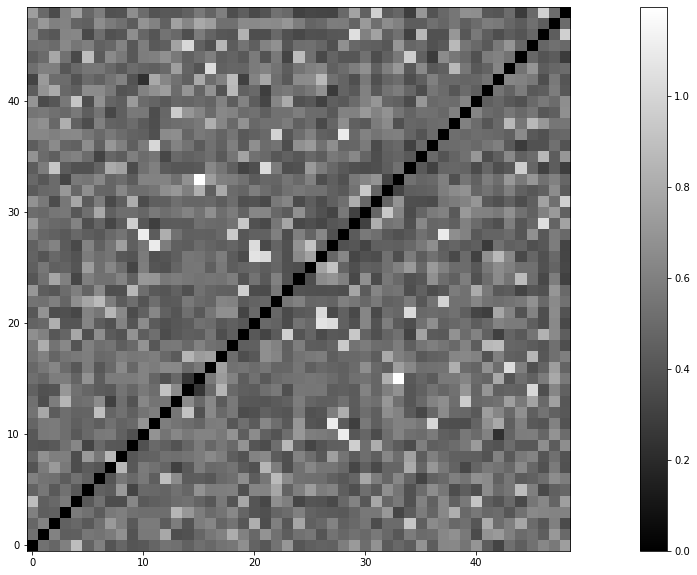

In [375]:
shm(R)

In [378]:
i = 0
x = X[i*batch_size:(i+1)*batch_size,:]

num_iters = 10
du_stat = np.zeros((num_iters, batch_size, num_hidden))
y_stat = np.zeros((num_iters, batch_size, num_hidden))
u_stat = np.zeros((num_iters, batch_size, num_hidden))

y = np.zeros((batch_size, num_hidden))
u = np.zeros((batch_size, num_hidden))
for it in range(num_iters):
    du = np.dot(x, W) - np.dot(y, R)
    u += dt * du
    y = a * relu(u - theta)
    du_stat[it] = np.linalg.norm(du)

    y_stat[it] = y.copy()
    u_stat[it] = u.copy()
    du_stat[it] = du.copy()

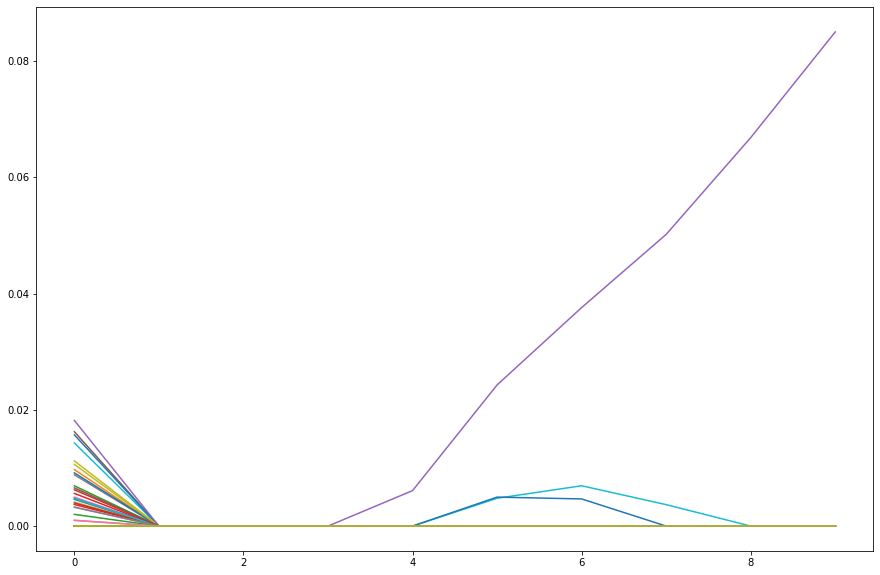

In [379]:
shl(y_stat[:,6])